# DISFE attack

- cosine similarity calculation

In [1]:
# Data preparation
import pandas as pd
import numpy as np

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Normalization and cosine distance
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

# Pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

import os

# Settings
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 8, 8

In [2]:
# Settings
block_sizes = ['16', '32', '64', '128']
feature_extractors = ['elasticface', 'arcface']

In [3]:
# Load dataframes as dict
df_genuine = {}

for blocksize in block_sizes:
    df_genuine[f'elasticface_{blocksize}'] = pd.read_csv(f"../dataframes/elasticface/lfw_view2_genuine_pemiu{blocksize}.csv", sep=",")
    df_genuine[f'arcface_{blocksize}'] = pd.read_csv(f"../dataframes/lfw_view2_genuine_pemiu{blocksize}.csv", sep=",")
    
df_genuine.keys()

dict_keys(['elasticface_16', 'arcface_16', 'elasticface_32', 'arcface_32', 'elasticface_64', 'arcface_64', 'elasticface_128', 'arcface_128'])

In [4]:
# Rename certain columns to remove number at the end

# mask = df_genuine['arcface_32'].columns.str.endswith('32')
# df_genuine['arcface_32'].loc[:, mask].columns

for blocksize in ['32', '64', '128']:
    df_genuine[f'arcface_{blocksize}'].rename(columns={
                              f"a_embedding_pemiu{blocksize}": "a_embedding_pemiu",
                              f"b_embedding_pemiu{blocksize}": "b_embedding_pemiu",
                              f"a_embedding_reconstructed{blocksize}": "a_embedding_reconstructed",
                              f"cos_sim_a_pemiu_a_pemiu_reconstructed{blocksize}": "cos_sim_a_pemiu_a_pemiu_reconstructed"}, 
                                    inplace=True)

In [5]:
# New names
for column, blocksize in zip(['arcface_32', 'arcface_64', 'arcface_128'], ['32', '64', '128']):
    mask = df_genuine[column].columns
    print(df_genuine[column].loc[:, mask].columns)

Index(['Unnamed: 0', 'a_img', 'a_embedding_pemiu', 'b_img',
       'b_embedding_pemiu', 'genuine', 'a_embedding_reconstructed',
       'cos_sim_a_pemiu_a_pemiu_reconstructed'],
      dtype='object')
Index(['Unnamed: 0', 'a_img', 'a_embedding_pemiu', 'b_img',
       'b_embedding_pemiu', 'genuine', 'a_embedding_reconstructed',
       'cos_sim_a_pemiu_a_pemiu_reconstructed'],
      dtype='object')
Index(['Unnamed: 0', 'a_img', 'a_embedding_pemiu', 'b_img',
       'b_embedding_pemiu', 'genuine', 'a_embedding_reconstructed',
       'cos_sim_a_pemiu_a_pemiu_reconstructed'],
      dtype='object')


In [6]:
df_genuine['arcface_16'].columns


Index(['Unnamed: 0', 'a_img', 'a_embedding_pemiu', 'b_img',
       'b_embedding_pemiu', 'genuine', 'a_embedding_reconstructed',
       'cos_sim_a_pemiu_a_pemiu_reconstructed'],
      dtype='object')

In [8]:
# Add embeddings
# target a: reconstruction attack pemiu
# target b: original embedding

# ArcFace
for blocksize in ['16', '32', '64', '128']:
    a_filename = [x.split('/')[-1].split('.')[0] for x in df_genuine[f'arcface_{blocksize}']['a_img']]
    b_filename = [x.split('/')[-1].split('.')[0] for x in df_genuine[f'arcface_{blocksize}']['b_img']]
    df_genuine[f'arcface_{blocksize}']['a_embedding_reconstruction_attack'] = [f"../recreate_icip2022_face_reconstruction/experiments/experiment_7_model1_pemiu_block_sizes/sample_images_pemiu{blocksize}_embeddings/{x}_pemiu{blocksize}.npy" for x in a_filename]
    df_genuine[f'arcface_{blocksize}']['b_embedding_original'] = [f"../data/features_cleaner/{x}.npy" for x in b_filename]
    
# Elasticface
for blocksize in ['16', '32', '64', '128']:
    a_filename = [x.split('/')[-1].split('.')[0] for x in df_genuine[f'elasticface_{blocksize}']['a_img']]
    b_filename = [x.split('/')[-1].split('.')[0] for x in df_genuine[f'elasticface_{blocksize}']['b_img']]
    df_genuine[f'elasticface_{blocksize}']['a_embedding_reconstruction_attack'] = [f"../recreate_icip2022_face_reconstruction/experiments/experiment_10_elastic/embeddings_pemiu{blocksize}/{x}_model4_pemiu{blocksize}.npy" for x in a_filename]
    df_genuine[f'elasticface_{blocksize}']['b_embedding_original'] = [f"../data/lfw_align_embeddings_elastic_pemiu{blocksize}/{x}.npy" for x in b_filename]
   

In [9]:
df_genuine['elasticface_16'].columns

Index(['Unnamed: 0', 'a_img', 'a_embedding_pemiu', 'b_img',
       'b_embedding_pemiu', 'genuine', 'a_embedding_reconstructed',
       'cos_sim_a_pemiu_a_pemiu_reconstructed',
       'a_embedding_reconstruction_attack', 'b_embedding_original'],
      dtype='object')

In [10]:
df_genuine['elasticface_16']

,Unnamed: 0,a_img,a_embedding_pemiu,b_img,b_embedding_pemiu,genuine,a_embedding_reconstructed,cos_sim_a_pemiu_a_pemiu_reconstructed,a_embedding_reconstruction_attack,b_embedding_original
0,0,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/lfw_align_embeddings_elastic_pemiu16/A...,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/lfw_align_embeddings_elastic_pemiu16/A...,True,../data/lfw_align_embeddings_elastic_pemiu16_r...,0.576046,../recreate_icip2022_face_reconstruction/exper...,../data/lfw_align_embeddings_elastic_pemiu16/A...
1,1,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic_pemiu16/A...,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic_pemiu16/A...,True,../data/lfw_align_embeddings_elastic_pemiu16_r...,0.821995,../recreate_icip2022_face_reconstruction/exper...,../data/lfw_align_embeddings_elastic_pemiu16/A...
2,2,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic_pemiu16/A...,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic_pemiu16/A...,True,../data/lfw_align_embeddings_elastic_pemiu16_r...,0.728067,../recreate_icip2022_face_reconstruction/exper...,../data/lfw_align_embeddings_elastic_pemiu16/A...
3,3,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/lfw_align_embeddings_elastic_pemiu16/A...,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/lfw_align_embeddings_elastic_pemiu16/A...,True,../data/lfw_align_embeddings_elastic_pemiu16_r...,0.516077,../recreate_icip2022_face_reconstruction/exper...,../data/lfw_align_embeddings_elastic_pemiu16/A...
4,4,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/lfw_align_embeddings_elastic_pemiu16/A...,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/lfw_align_embeddings_elastic_pemiu16/A...,True,../data/lfw_align_embeddings_elastic_pemiu16_r...,0.666375,../recreate_icip2022_face_reconstruction/exper...,../data/lfw_align_embeddings_elastic_pemiu16/A...
...,...,...,...,...,...,...,...,...,...,...
2995,5695,../data/lfw_align/Vladimir_Voltchkov/Vladimir_...,../data/lfw_align_embeddings_elastic_pemiu16/V...,../data/lfw_align/Vladimir_Voltchkov/Vladimir_...,../data/lfw_align_embeddings_elastic_pemiu16/V...,True,../data/lfw_align_embeddings_elastic_pemiu16_r...,0.502934,../recreate_icip2022_face_reconstruction/exper...,../data/lfw_align_embeddings_elastic_pemiu16/V...
2996,5696,../data/lfw_align/Wang_Yi/Wang_Yi_0001.png,../data/lfw_align_embeddings_elastic_pemiu16/W...,../data/lfw_align/Wang_Yi/Wang_Yi_0002.png,../data/lfw_align_embeddings_elastic_pemiu16/W...,True,../data/lfw_align_embeddings_elastic_pemiu16_r...,0.698034,../recreate_icip2022_face_reconstruction/exper...,../data/lfw_align_embeddings_elastic_pemiu16/W...
2997,5697,../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...,../data/lfw_align_embeddings_elastic_pemiu16/Z...,../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...,../data/lfw_align_embeddings_elastic_pemiu16/Z...,True,../data/lfw_align_embeddings_elastic_pemiu16_r...,0.683992,../recreate_icip2022_face_reconstruction/exper...,../data/lfw_align_embeddings_elastic_pemiu16/Z...
2998,5698,../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0001.png,../data/lfw_align_embeddings_elastic_pemiu16/Z...,../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0003.png,../data/lfw_align_embeddings_elastic_pemiu16/Z...,True,../data/lfw_align_embeddings_elastic_pemiu16_r...,0.728986,../recreate_icip2022_face_reconstruction/exper...,../data/lfw_align_embeddings_elastic_pemiu16/Z...


## Calculate cos_sim

In [11]:
# Cosine similarity according to Terhörst PEMIU implementation
def cos_sim(a, b):
    a, b = a.reshape(-1), b.reshape(-1)
    return np.dot(a,b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [12]:
feature_extractors

['elasticface', 'arcface']

In [13]:
# Load embeddings
embeddings = {}
for fe in feature_extractors:
    for blocksize in block_sizes:
        embeddings[f'{fe}_{blocksize}_a'] = df_genuine[f"{fe}_{blocksize}"]['a_embedding_reconstruction_attack'].apply(lambda x: np.load(x)).tolist()
        embeddings[f'{fe}_{blocksize}_b'] = df_genuine[f"{fe}_{blocksize}"]['b_embedding_original'].apply(lambda x: np.load(x)).tolist()

        # Calculate cosine similarity using scipy spacial distance
        df_genuine[f'{fe}_{blocksize}']['cos_sim_a_attack_b_original'] = [(cos_sim(x, y)) for x, y in zip(embeddings[f'{fe}_{blocksize}_a'], embeddings[f'{fe}_{blocksize}_b'])]

In [14]:
# DF edit

genuine_arcface, genuine_elasticface = pd.DataFrame(), pd.DataFrame()

for blocksize in block_sizes:
    genuine_arcface[f'disfe_{blocksize}'] = df_genuine[f'arcface_{blocksize}']['cos_sim_a_attack_b_original']
    genuine_elasticface[f'disfe_{blocksize}'] = df_genuine[f'elasticface_{blocksize}']['cos_sim_a_attack_b_original']

In [15]:
genuine_arcface.head()

,disfe_16,disfe_32,disfe_64,disfe_128
0,-0.012128,0.117064,0.073254,0.240811
1,-0.035553,0.228652,0.040219,0.052360
2,0.034778,-0.029991,-0.093995,-0.004395
3,0.025858,-0.066945,0.239264,-0.084180
4,0.105260,0.176509,0.114846,0.345636


In [16]:
genuine_arcface.max()

disfe_16     0.314868
disfe_32     0.324178
disfe_64     0.448211
disfe_128    0.621925
dtype: float64

In [17]:
genuine_arcface.min()

disfe_16    -0.218278
disfe_32    -0.238554
disfe_64    -0.242530
disfe_128   -0.209879
dtype: float64

In [18]:
genuine_elasticface.head()

,disfe_16,disfe_32,disfe_64,disfe_128
0,0.082521,-0.023524,0.084124,0.085298
1,-0.038807,-0.022590,0.064234,0.007191
2,0.026359,-0.084521,0.062464,-0.038141
3,0.027602,0.047276,0.030488,-0.048395
4,-0.056809,0.019595,-0.039891,0.122400


In [19]:
genuine_elasticface.max()

disfe_16     0.135698
disfe_32     0.176397
disfe_64     0.207527
disfe_128    0.543319
dtype: float32

In [20]:
genuine_elasticface.min()

disfe_16    -0.155690
disfe_32    -0.160752
disfe_64    -0.143865
disfe_128   -0.165669
dtype: float32

In [21]:
genuine_arcface.head()

,disfe_16,disfe_32,disfe_64,disfe_128
0,-0.012128,0.117064,0.073254,0.240811
1,-0.035553,0.228652,0.040219,0.052360
2,0.034778,-0.029991,-0.093995,-0.004395
3,0.025858,-0.066945,0.239264,-0.084180
4,0.105260,0.176509,0.114846,0.345636


In [22]:
genuine_elasticface.head()

,disfe_16,disfe_32,disfe_64,disfe_128
0,0.082521,-0.023524,0.084124,0.085298
1,-0.038807,-0.022590,0.064234,0.007191
2,0.026359,-0.084521,0.062464,-0.038141
3,0.027602,0.047276,0.030488,-0.048395
4,-0.056809,0.019595,-0.039891,0.122400


In [23]:
# Cos_sim PEMIU
df_cos_sim_pemiu = pd.read_csv(f"{experiment_7_path}cosine_similarity/cos_sim_samples_pemiu.csv", index_col='Unnamed: 0')
df_cos_sim_unprotected = pd.read_csv(f"{experiment_7_path}cosine_similarity/cos_sim_samples_unprotected.csv", index_col='Unnamed: 0')


NameError: name 'experiment_7_path' is not defined

In [25]:
th_arcface = {'FMR1000_TH': 0.247557, 'FMR100_TH': 0.170457, 'FMR10_TH': 0.095468}
th_elasticface = {'FMR1000_TH': 0.288248, 'FMR100_TH': 0.203831, 'FMR10_TH': 0.113246}

In [26]:
# ArcFace
for blocksize in block_sizes:
    successful_attacks = []
    for i, (row) in enumerate(th_arcface):
        num = len(genuine_arcface[ genuine_arcface[f'disfe_{blocksize}'] > th_arcface[row] ])
        num = round((num / len(genuine_arcface[f'disfe_{blocksize}']) * 100), 2)
        successful_attacks.append(num)

    print(f"arcface {blocksize}")
    for element, th in zip(successful_attacks, th_arcface):
        print(f"{th}: {element}%")
    print("-----------")

arcface 16
FMR1000_TH: 0.13%
FMR100_TH: 1.87%
FMR10_TH: 15.63%
-----------
arcface 32
FMR1000_TH: 0.57%
FMR100_TH: 4.13%
FMR10_TH: 20.3%
-----------
arcface 64
FMR1000_TH: 4.2%
FMR100_TH: 11.8%
FMR10_TH: 31.8%
-----------
arcface 128
FMR1000_TH: 16.37%
FMR100_TH: 31.3%
FMR10_TH: 49.93%
-----------


In [27]:
# ElasticFace
for blocksize in block_sizes:
    successful_attacks = []
    for i, (row) in enumerate(th_elasticface):
        num = len(genuine_elasticface[ genuine_elasticface[f'disfe_{blocksize}'] > th_elasticface[row] ])
        num = round((num / len(genuine_elasticface[f'disfe_{blocksize}']) * 100), 2)
        successful_attacks.append(num)

    print(f"elasticface {blocksize}")
    for element, th in zip(successful_attacks, th_elasticface):
        print(f"{th}: {element}%")
    print("-----------")

elasticface 16
FMR1000_TH: 0.0%
FMR100_TH: 0.0%
FMR10_TH: 0.47%
-----------
elasticface 32
FMR1000_TH: 0.0%
FMR100_TH: 0.0%
FMR10_TH: 1.07%
-----------
elasticface 64
FMR1000_TH: 0.0%
FMR100_TH: 0.07%
FMR10_TH: 2.93%
-----------
elasticface 128
FMR1000_TH: 0.37%
FMR100_TH: 1.83%
FMR10_TH: 14.0%
-----------


In [36]:
# Experiment 7 folder (contains evaluation results with ArcFace)
experiment_7_path = "../recreate_icip2022_face_reconstruction/experiments/experiment_7_model1_pemiu_block_sizes/"
# Experiment 10 folder (contains ElasticFace)
experiment_10_path = "../recreate_icip2022_face_reconstruction/experiments/experiment_10_elastic/"
# Cos_sim PEMIU
df_cos_sim_pemiu = pd.read_csv(f"{experiment_7_path}cosine_similarity/cos_sim_samples_pemiu.csv", index_col='Unnamed: 0')
df_cos_sim_unprotected = pd.read_csv(f"{experiment_7_path}cosine_similarity/cos_sim_samples_unprotected.csv", index_col='Unnamed: 0')
# DataFrame modifications
df_cos_sim_all = pd.merge(df_cos_sim_unprotected, df_cos_sim_pemiu, on='filename', how='outer')

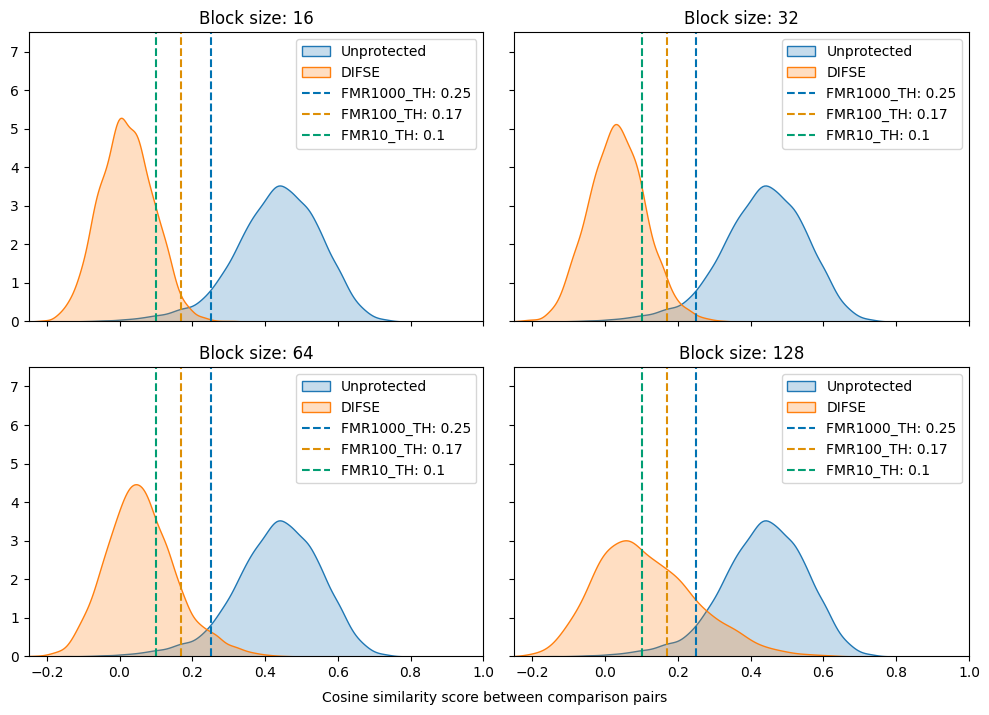

In [41]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,
                        figsize = (10, 7),
                        tight_layout = True)

# Title
# fig.suptitle(f"SISFE Attack: Reconstructed images from unprotected embeddings,\n" \
#              f"PEMIU enhanced embeddings at varying block sizes, system thresholds, using {face_extractor}")
#fig.suptitle(f"{face_extractor}")
# Settings
#labels_th = ['FMR1000', 'FMR100', 'FMR10']
colors = ["b", "r", "g", "c"]

for i, (blocksize, ax) in enumerate(zip(block_sizes, fig.get_axes())):
    sns.kdeplot(df_cos_sim_all[f'cos_sim_reconstructed_vs_real'], ax=ax, label=f"Unprotected", fill=True)
    sns.kdeplot(df_genuine[f'arcface_{blocksize}'][f'cos_sim_a_attack_b_original'], ax=ax, label=f"DIFSE", fill=True)
    #sns.kdeplot(df_cos_sim_all[f'cos_sim_pemiu{blocksize}_vs_real'], ax=ax, label=f"PEMIU protected", fill=True)
    ax.set_title(f"Block size: {blocksize}")
    ax.set_xlim(-0.25, 1)
    ax.set_ylim(0, 7.5)
    ax.label_outer()
    # Thresholds
    for index, row in enumerate(th_arcface):
        ax.axvline(x = round(((th_arcface[row])), 2), 
                   color = sns.color_palette("colorblind")[index], 
                   linestyle="--",
                   label = f'{list(th_arcface.keys())[index]}: {round(th_arcface[row], 2)}')
    ax.legend()
    ax.set(xlabel="")
    ax.set(ylabel="")
    # .grid(visible=True, which='major', color='black', linewidth=0.075)

# plt.xlabel = "Normalized cosine similarity score between comparison pairs"
fig.text(0.5, -0.01, 'Cosine similarity score between comparison pairs', ha='center')
    
# Render plot
plt.xlim([-0.25, 1])
#plt.savefig(f'{plt_savepath}03_02_sisfe_attack_pemiu_at_system_threshold.svg', bbox_inches='tight')
plt.show()

In [42]:
# Cos_sim PEMIU
df_cos_sim_pemiu = pd.read_csv(f"{experiment_10_path}cosine_similarity/cos_sim_samples_pemiu.csv", index_col='Unnamed: 0')
df_cos_sim_unprotected = pd.read_csv(f"{experiment_10_path}cosine_similarity/cos_sim_samples_unprotected.csv", index_col='Unnamed: 0')
# DataFrame modifications
df_cos_sim_all = pd.merge(df_cos_sim_unprotected, df_cos_sim_pemiu, on='filename', how='outer')

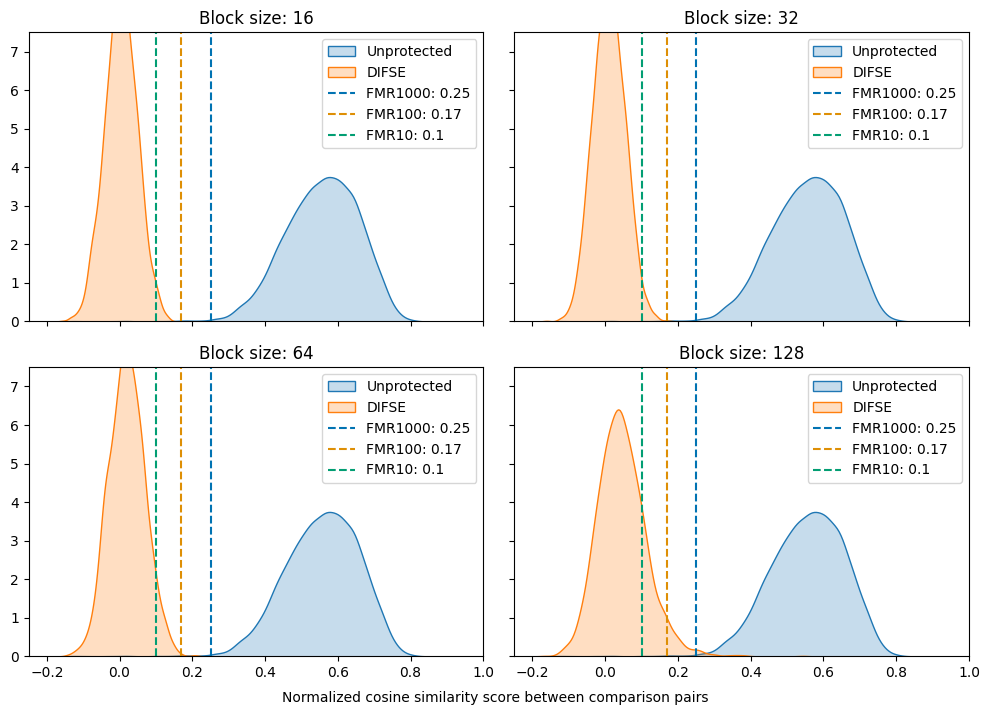

In [43]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,
                        figsize = (10, 7),
                        tight_layout = True)

# Title
# fig.suptitle(f"SISFE Attack: Reconstructed images from unprotected embeddings,\n" \
#              f"PEMIU enhanced embeddings at varying block sizes, system thresholds, using {face_extractor}")
#fig.suptitle(f"{face_extractor}")
# Settings
labels_th = ['FMR1000', 'FMR100', 'FMR10']
colors = ["b", "r", "g", "c"]

for i, (blocksize, ax) in enumerate(zip(block_sizes, fig.get_axes())):
    sns.kdeplot(df_cos_sim_all[f'cos_sim_reconstructed_vs_real'], ax=ax, label=f"Unprotected", fill=True)
    sns.kdeplot(df_genuine[f'elasticface_{blocksize}'][f'cos_sim_a_attack_b_original'], ax=ax, label=f"DIFSE", fill=True)
    #sns.kdeplot(df_cos_sim_all[f'cos_sim_pemiu{blocksize}_vs_real_normalized'], ax=ax, label=f"PEMIU protected", fill=True)
    ax.set_title(f"Block size: {blocksize}")
    ax.set_xlim(-0.25, 1)
    ax.set_ylim(0, 7.5)
    ax.label_outer()
    # Thresholds
    for index, row in enumerate(th_arcface):
        ax.axvline(x = round(((th_arcface[row])), 2), 
                   color = sns.color_palette("colorblind")[index], 
                   linestyle="--",
                   label = f'{labels_th[index]}: {round(th_arcface[row], 2)}')
    ax.legend()
    ax.set(xlabel="")
    ax.set(ylabel="")
    # .grid(visible=True, which='major', color='black', linewidth=0.075)

# plt.xlabel = "Normalized cosine similarity score between comparison pairs"
fig.text(0.5, -0.01, 'Normalized cosine similarity score between comparison pairs', ha='center')
    
# Render plot
plt.xlim([-0.25, 1])
#plt.savefig(f'{plt_savepath}03_02_sisfe_attack_pemiu_at_system_threshold.svg', bbox_inches='tight')
plt.show()

In [174]:
df_genuine['arcface_16']['cos_sim_a_attack_b_original'].max()

0.346662713938559

In [186]:
df_genuine['arcface_128'][ df_genuine['arcface_128']['cos_sim_a_attack_b_original'] > 0.3 ]

,Unnamed: 0,a_img,a_embedding_pemiu,b_img,b_embedding_pemiu,genuine,a_embedding_reconstructed,cos_sim_a_pemiu_a_pemiu_reconstructed,a_embedding_reconstruction_attack,b_embedding_original,cos_sim_a_attack_b_original,cos_sim_a_attack_b_original_normalized
0,0,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/features_cleaner_pemiu128/Abel_Pacheco...,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/features_cleaner_pemiu128/Abel_Pacheco...,True,../data/features_cleaner_pemiu128_reconstructe...,0.735583,../recreate_icip2022_face_reconstruction/exper...,../data/features_cleaner/Abel_Pacheco_0004.npy,0.314158,0.485112
3,3,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/features_cleaner_pemiu128/Amber_Tambly...,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/features_cleaner_pemiu128/Amber_Tambly...,True,../data/features_cleaner_pemiu128_reconstructe...,0.733785,../recreate_icip2022_face_reconstruction/exper...,../data/features_cleaner/Amber_Tamblyn_0002.npy,0.510153,0.638283
17,17,../data/lfw_align/Barbara_Brezigar/Barbara_Bre...,../data/features_cleaner_pemiu128/Barbara_Brez...,../data/lfw_align/Barbara_Brezigar/Barbara_Bre...,../data/features_cleaner_pemiu128/Barbara_Brez...,True,../data/features_cleaner_pemiu128_reconstructe...,0.680434,../recreate_icip2022_face_reconstruction/exper...,../data/features_cleaner/Barbara_Brezigar_0002...,0.536812,0.659117
18,18,../data/lfw_align/Benjamin_Netanyahu/Benjamin_...,../data/features_cleaner_pemiu128/Benjamin_Net...,../data/lfw_align/Benjamin_Netanyahu/Benjamin_...,../data/features_cleaner_pemiu128/Benjamin_Net...,True,../data/features_cleaner_pemiu128_reconstructe...,0.760452,../recreate_icip2022_face_reconstruction/exper...,../data/features_cleaner/Benjamin_Netanyahu_00...,0.329345,0.496981
19,19,../data/lfw_align/Benjamin_Netanyahu/Benjamin_...,../data/features_cleaner_pemiu128/Benjamin_Net...,../data/lfw_align/Benjamin_Netanyahu/Benjamin_...,../data/features_cleaner_pemiu128/Benjamin_Net...,True,../data/features_cleaner_pemiu128_reconstructe...,0.773653,../recreate_icip2022_face_reconstruction/exper...,../data/features_cleaner/Benjamin_Netanyahu_00...,0.320718,0.490238
...,...,...,...,...,...,...,...,...,...,...,...,...
2975,5675,../data/lfw_align/Simon_Cowell/Simon_Cowell_00...,../data/features_cleaner_pemiu128/Simon_Cowell...,../data/lfw_align/Simon_Cowell/Simon_Cowell_00...,../data/features_cleaner_pemiu128/Simon_Cowell...,True,../data/features_cleaner_pemiu128_reconstructe...,0.726353,../recreate_icip2022_face_reconstruction/exper...,../data/features_cleaner/Simon_Cowell_0002.npy,0.350629,0.513614
2978,5678,../data/lfw_align/Slobodan_Milosevic/Slobodan_...,../data/features_cleaner_pemiu128/Slobodan_Mil...,../data/lfw_align/Slobodan_Milosevic/Slobodan_...,../data/features_cleaner_pemiu128/Slobodan_Mil...,True,../data/features_cleaner_pemiu128_reconstructe...,0.625113,../recreate_icip2022_face_reconstruction/exper...,../data/features_cleaner/Slobodan_Milosevic_00...,0.367683,0.526942
2988,5688,../data/lfw_align/Tommy_Robredo/Tommy_Robredo_...,../data/features_cleaner_pemiu128/Tommy_Robred...,../data/lfw_align/Tommy_Robredo/Tommy_Robredo_...,../data/features_cleaner_pemiu128/Tommy_Robred...,True,../data/features_cleaner_pemiu128_reconstructe...,0.593619,../recreate_icip2022_face_reconstruction/exper...,../data/features_cleaner/Tommy_Robredo_0003.npy,0.384416,0.540019
2989,5689,../data/lfw_align/Tommy_Robredo/Tommy_Robredo_...,../data/features_cleaner_pemiu128/Tommy_Robred...,../data/lfw_align/Tommy_Robredo/Tommy_Robredo_...,../data/features_cleaner_pemiu128/Tommy_Robred...,True,../data/features_cleaner_pemiu128_reconstructe...,0.860178,../recreate_icip2022_face_reconstruction/exper...,../data/features_cleaner/Tommy_Robredo_0003.npy,0.384416,0.540019
